<a href="https://colab.research.google.com/github/kuanthum/bikes_dataton/blob/main/model_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf

In [5]:
df_train = pd.read_excel(r'/content/bike_train.xlsx')
df_test = pd.read_excel(r'/content/bike_test.xlsx')

### Data Exploration

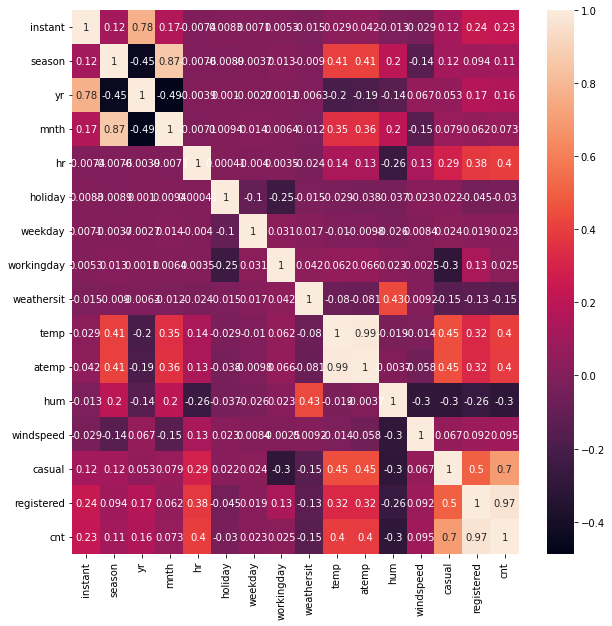

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.corr(),annot=True)
plt.show()

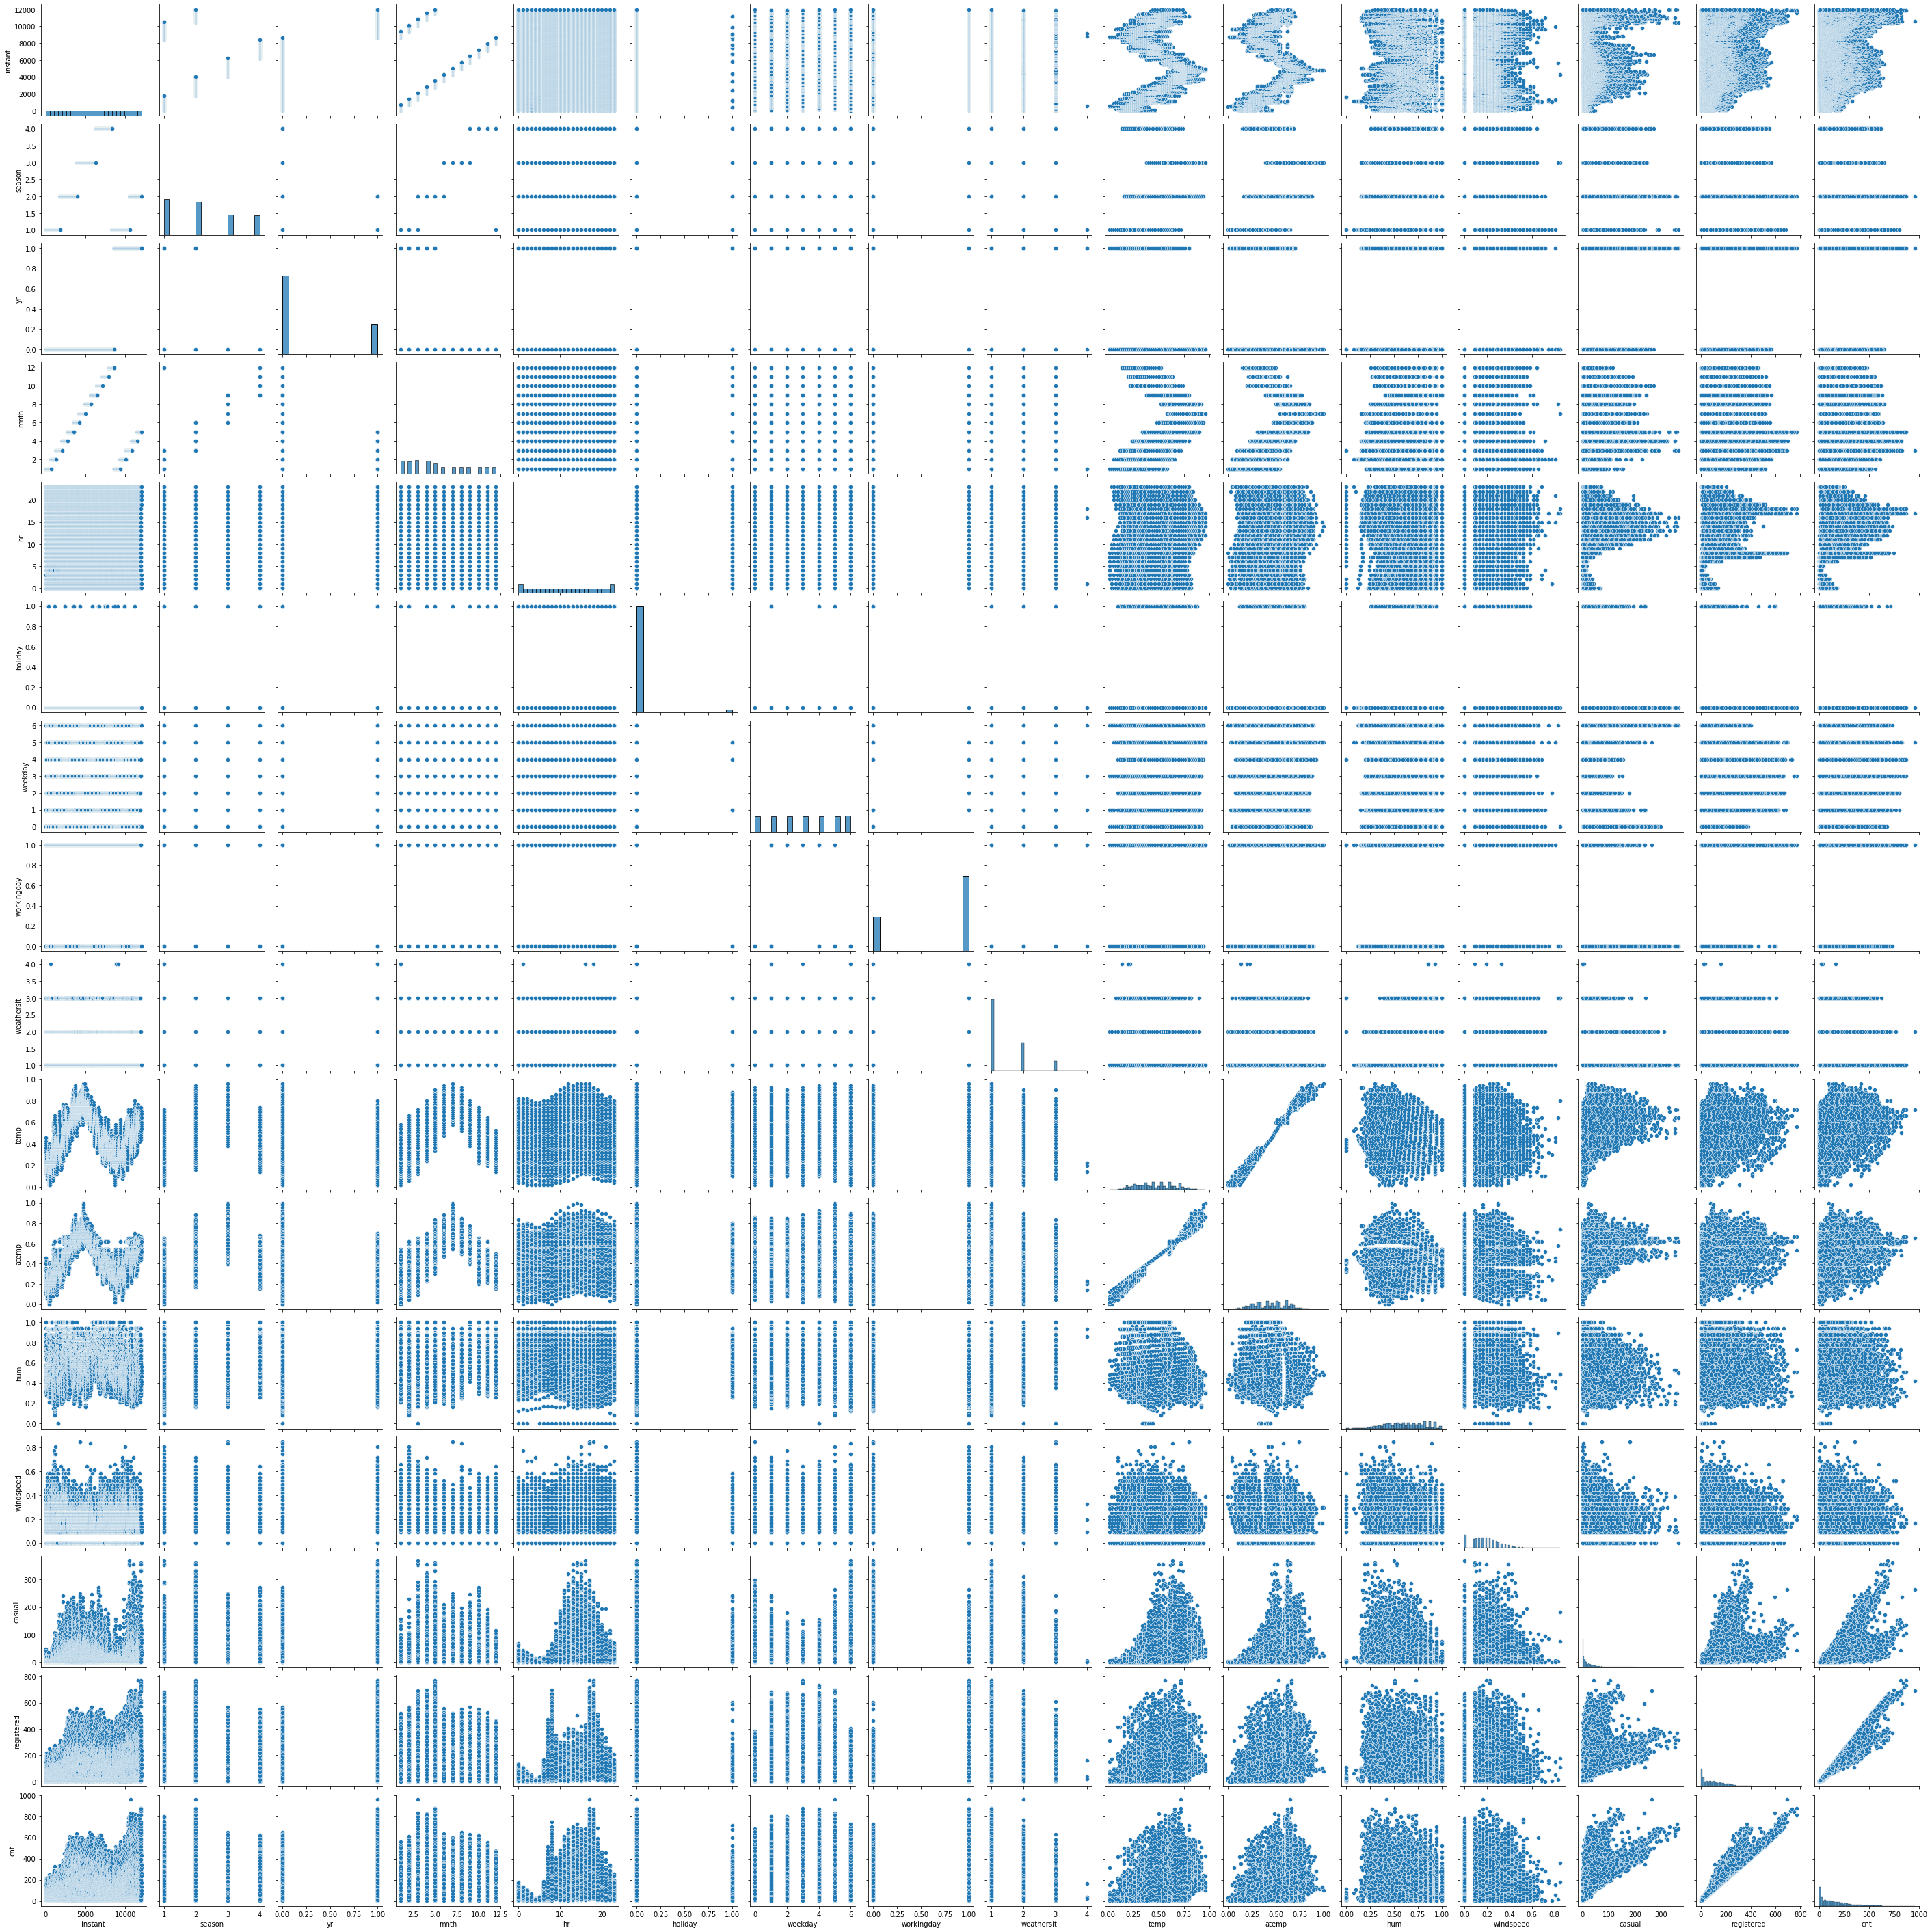

In [7]:
sns.pairplot(df_train)

### Data Pre-Procesing

In [8]:
df_train.head(10)

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   
5        6 2011-01-01       1   0     1   5        0        6           0   
6        7 2011-01-01       1   0     1   6        0        6           0   
7        8 2011-01-01       1   0     1   7        0        6           0   
8        9 2011-01-01       1   0     1   8        0        6           0   
9       10 2011-01-01       1   0     1   9        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81     0.0000       3          13   16  
1           1  0.22  0.2727  0.80     0.0000       8          32   40  
2           1  0.22  0.2727  0.80     0.0000       5          27   32  
3           1  0.24  0.2879  0.75     0.0000       3          10   13  
4           1  0.24  0.2879  0.75     0.0000       0           1    1  
5           2  0.24  0.2576  0.75     0.0896       0           1    1  
6           1  0.22  0.2727  0.80     0.0000       2           0    2  
7           1  0.20  0.2576  0.86     0.0000       1           2    3  
8           1  0.24  0.2879  0.75     0.0000       1           7    8  
9           1  0.32  0.3485  0.76     0.0000       8           6   14

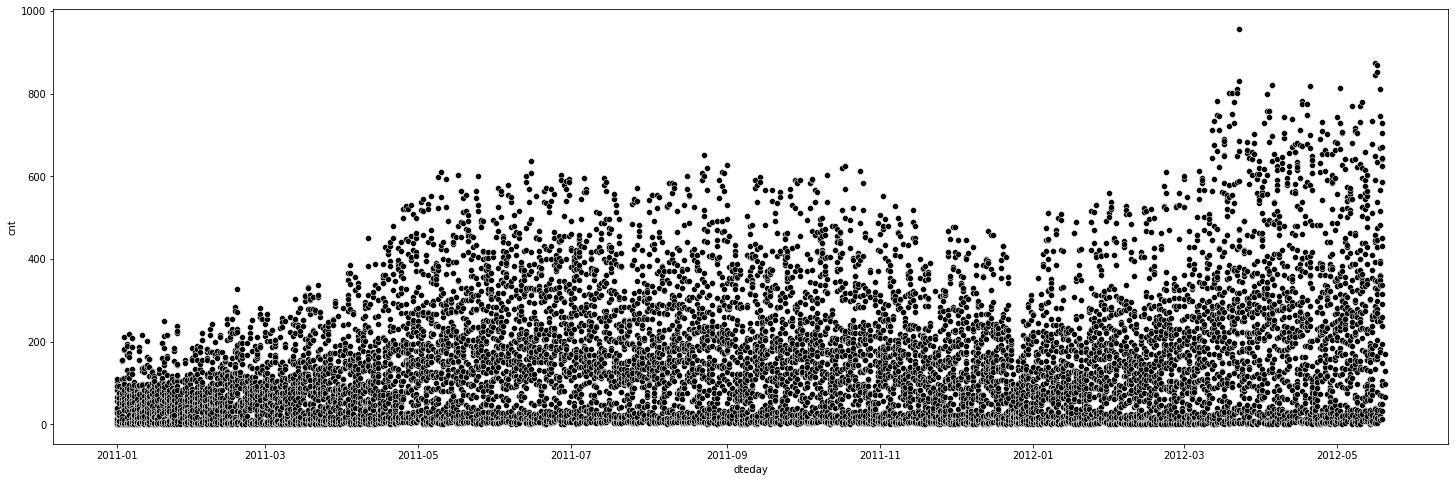

In [11]:
plt.figure(figsize=(25,8))
ax = sns.scatterplot(
    data=df_train, x="dteday", y="cnt", color="black",
)

In [12]:
sample = df_train[(df_train['instant'] > 11500)]

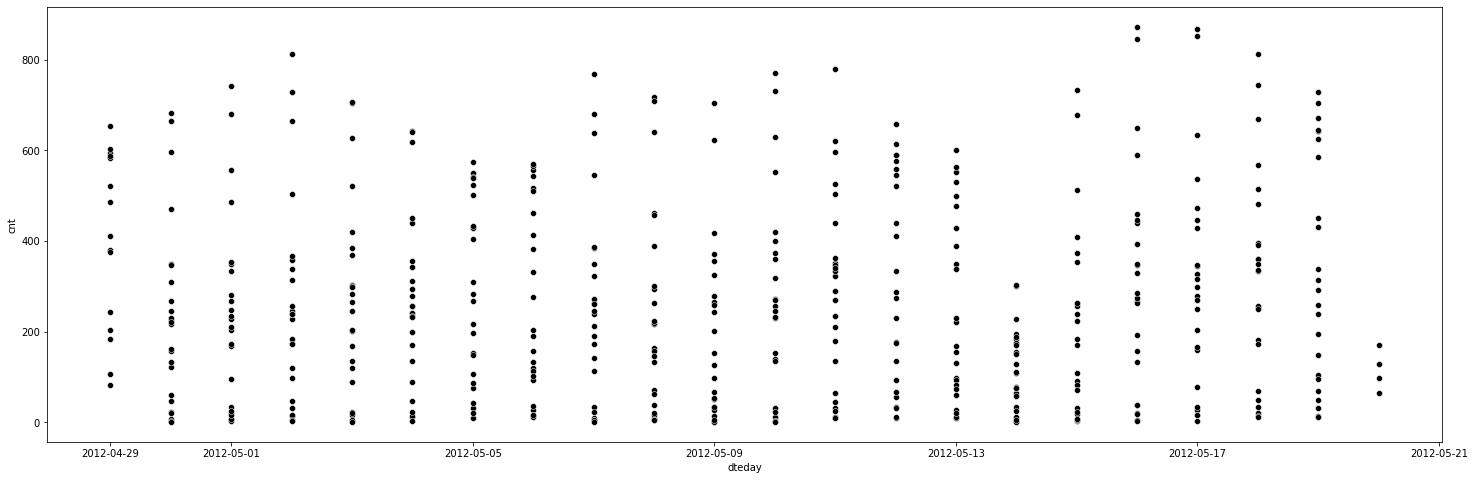

In [14]:
plt.figure(figsize=(25,8))
ax = sns.scatterplot(
    data=sample, x="dteday", y="cnt", color="black",
)

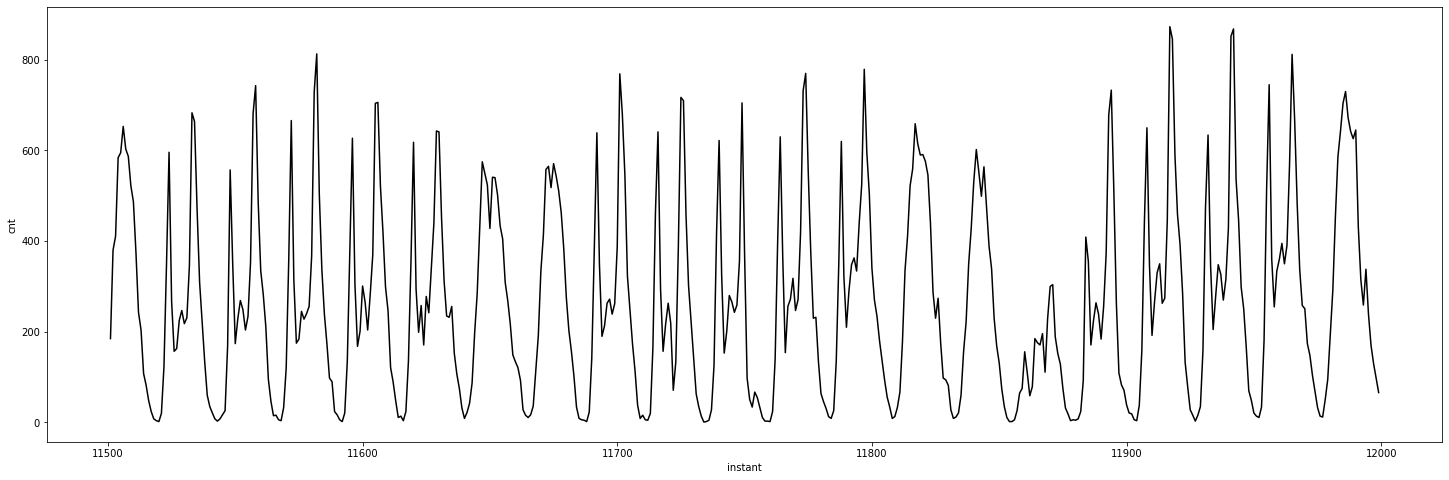

In [16]:
plt.figure(figsize=(25,8))
ax = sns.lineplot(
    data=sample, x="instant", y="cnt", color="black",
)
# En este gráfico podemos apreciar la estacionalidad diaria
# Los días de semana presentan una baja, es decir, a cierta hora de la mañana y a cierta hora de la tarde tenemos picos
# En cambio los fines de semana no existe ese decaimiento

### Buscar valores faltantes

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     11999 non-null  int64         
 1   dteday      11999 non-null  datetime64[ns]
 2   season      11999 non-null  int64         
 3   yr          11999 non-null  int64         
 4   mnth        11999 non-null  int64         
 5   hr          11999 non-null  int64         
 6   holiday     11999 non-null  int64         
 7   weekday     11999 non-null  int64         
 8   workingday  11999 non-null  int64         
 9   weathersit  11999 non-null  int64         
 10  temp        11999 non-null  float64       
 11  atemp       11999 non-null  float64       
 12  hum         11999 non-null  float64       
 13  windspeed   11999 non-null  float64       
 14  casual      11999 non-null  int64         
 15  registered  11999 non-null  int64         
 16  cnt         11999 non-

In [22]:
df_train.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

### Manual Preproccesing

In [23]:
# Eliminación de columnas
# dteday por que ya tenemos la fecha desglosada en valores numéricos representando años meses días y horas
# temp por existir total correlación con sensación térmica, además este valor incluye humedad por lo que también podemos eliminar esa feature
# hum
# winspeed por que aparentemente no tiene demasiada relevancia

df_train.drop(columns=['dteday', 'temp', 'hum', 'windspeed'], inplace=True)                                #Eliminamos la columna con fechas ya que está desglosada y tenemos 'instant'. Windspeed parece te 
df_test.drop(columns=['dteday', 'temp', 'hum', 'windspeed'], inplace=True)                                 #Temp tiene las mismas implicaciones que atemp, nos quedamos con la sensación térmica para además eliminar la humedad
target = df_train.pop('cnt')                                                                               #Guardamos el target
columns = set(list(df_train.columns.values)).intersection(list(df_test.columns.values))                    #Eliminar columnas que no estan en el test dataset: casual, registered
drop = [x for x in df_train.columns if x not in columns]          
df_train.drop(columns=drop, inplace=True)         

In [24]:
# Pasamos instant al final para ordenar las features en categoricas y numéricas
instant = df_train.pop('instant')   
instant_2 = df_test.pop('instant')
df_train = pd.concat([df_train,instant], axis=1)
df_test = pd.concat([df_test,instant_2], axis=1)

In [25]:
df_train = pd.concat([df_train, target], axis=1)

In [26]:
df_train.head(1)

season  yr  mnth  hr  holiday  weekday  workingday  weathersit   atemp  \
0       1   0     1   0        0        6           0           1  0.2879   

   instant  cnt  
0        1   16

### Preparamos data para entrenar el modelo

In [27]:
X_train = df_train.to_numpy()[:, :-1]
y_train = target.to_numpy()
X_train.shape, y_train.shape

((11999, 10), (11999,))

In [28]:

X_test = df_test.to_numpy()#[:, :-1]
y_test = df_test.to_numpy()[:, 0]
X_test.shape, y_test.shape

((5380, 10), (5380,))

### Machine learning
# Eleccion de modelo e hyperparametros


In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as rmse

In [31]:
# Utilizamos Grid Search para elegir los mejores hyperparametros

model = GradientBoostingRegressor()

grid = {
    "n_estimators": [70, 100],       # Cantidad de arboles máximos
    "learning_rate": [0.1],          # Tamaño de pasos del descenso del gradiente
    "min_samples_split": [50, 200],  # Cantidad máxima de valores por clasificación
    "max_depth":  [5, 7, 8],         # Profundidad máxima de los árboles
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# Define the grid search procedure
grid_search = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           scoring = ["r2","neg_root_mean_squared_error"],
                           refit = "r2",
                           cv=5)
# Execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # summarize all scores that were evaluated

Best: 0.782323 using {'learning_rate': 0.1, 'max_depth': 8, 'min_samples_split': 50, 'n_estimators': 100}


In [32]:
grid_result.best_score_

0.7823229991713576

In [ ]:
grid_result.cv_results_

In [40]:
grid_result.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_samples_split': 50,
 'n_estimators': 100}

In [41]:
gbr = GradientBoostingRegressor(n_estimators=100,
                                learning_rate=0.1,
                                max_depth=8,
                                min_samples_split=50,
                                )

In [42]:
gbr.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=8, min_samples_split=50)

In [44]:
# Evaluamos raiz del error cuadratico medio
rmse(y_train, gbr.predict(X_train))

560.1333183455245

In [46]:
prediction = gbr.predict(X_train)
prediction

array([ 20.89911216,  23.81934989,  21.27120684, ..., 125.13020597,
        99.91622355,  72.50437569])

In [48]:
y_train

array([ 16,  40,  32, ..., 130,  98,  66])

In [ ]:
df_predicted = df_train

In [49]:
df_predicted['predicted'] = prediction

In [50]:
df_predicted['value'] = y_train

In [51]:
df_predicted

season  yr  mnth  hr  holiday  weekday  workingday  weathersit   atemp  \
0           1   0     1   0        0        6           0           1  0.2879   
1           1   0     1   1        0        6           0           1  0.2727   
2           1   0     1   2        0        6           0           1  0.2727   
3           1   0     1   3        0        6           0           1  0.2879   
4           1   0     1   4        0        6           0           1  0.2879   
...       ...  ..   ...  ..      ...      ...         ...         ...     ...   
11994       2   1     5  23        0        6           0           1  0.6212   
11995       2   1     5   0        0        0           0           1  0.5455   
11996       2   1     5   1        0        0           0           1  0.5303   
11997       2   1     5   2        0        0           0           1  0.5303   
11998       2   1     5   3        0        0           0           1  0.5152   

       instant  cnt   predicted  value  
0            1   16   20.899112     16  
1            2   40   23.819350     40  
2            3   32   21.271207     32  
3            4   13    3.513859     13  
4            5    1   -3.105744      1  
...        ...  ...         ...    ...  
11994    11995  239  237.588394    239  
11995    11996  170  157.770887    170  
11996    11997  130  125.130206    130  
11997    11998   98   99.916224     98  
11998    11999   66   72.504376     66  

[11999 rows x 13 columns]

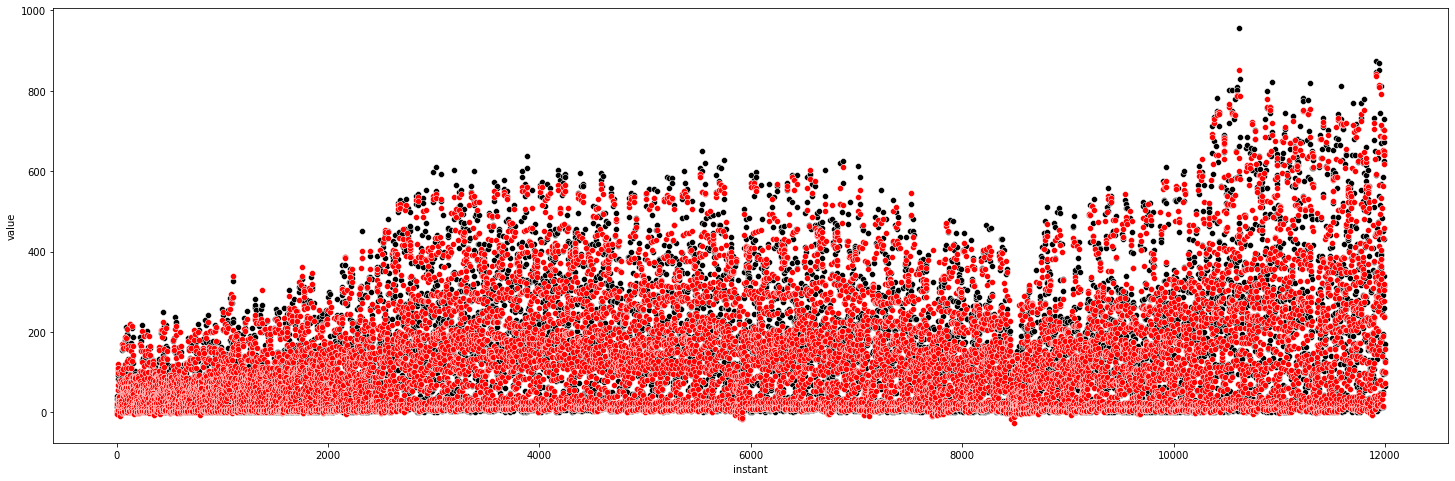

In [52]:
plt.figure(figsize=(25,8))
ax = sns.scatterplot(
    data=df_train, x="instant", y="value", color="black",
)
ax2 = sns.scatterplot(
    data=df_train, x='instant', y='predicted', color='red'
)

In [54]:
sample = df_predicted[(df_predicted['instant'] > 11500)]

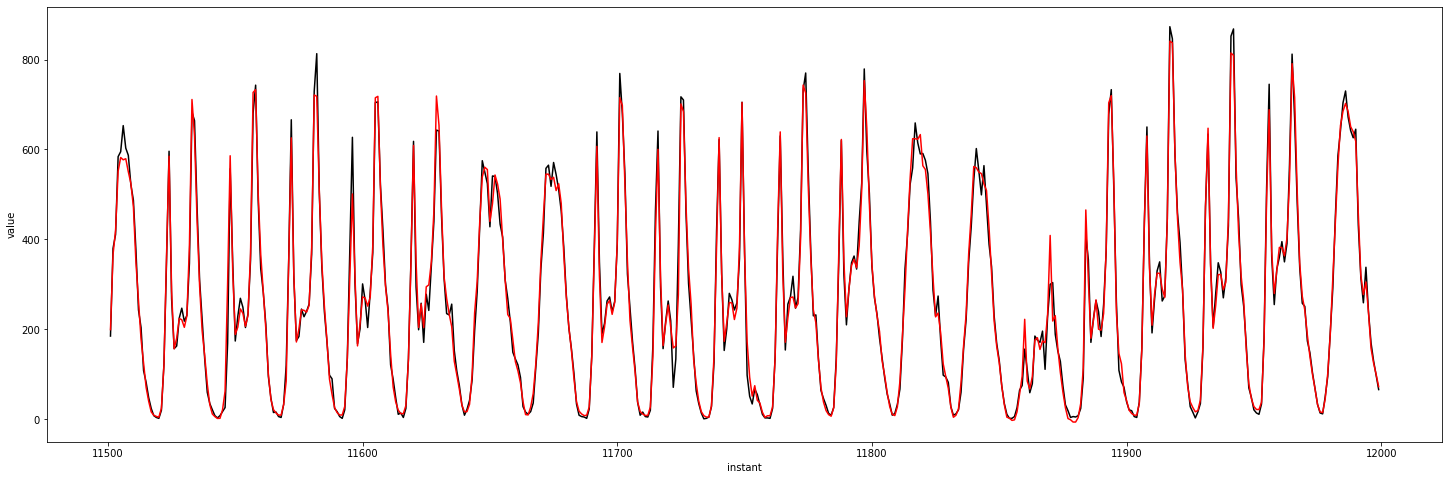

In [55]:
plt.figure(figsize=(25,8))
ax = sns.lineplot(
    data=sample, x="instant", y="value", color="black",
)
ax2 = sns.lineplot(
    data=sample, x='instant', y='predicted', color='red'
)

In [57]:
test_prediction = gbr.predict(X_test)

In [69]:
csv = pd.DataFrame(test_prediction, columns=['pred'])

In [70]:
csv.head(5)

pred
0   37.857808
1   34.679211
2   43.380662
3   98.443791
4  171.456710

In [72]:
csv.to_csv('kuanthum.csv')

In [58]:
df_test['predict'] = test_prediction

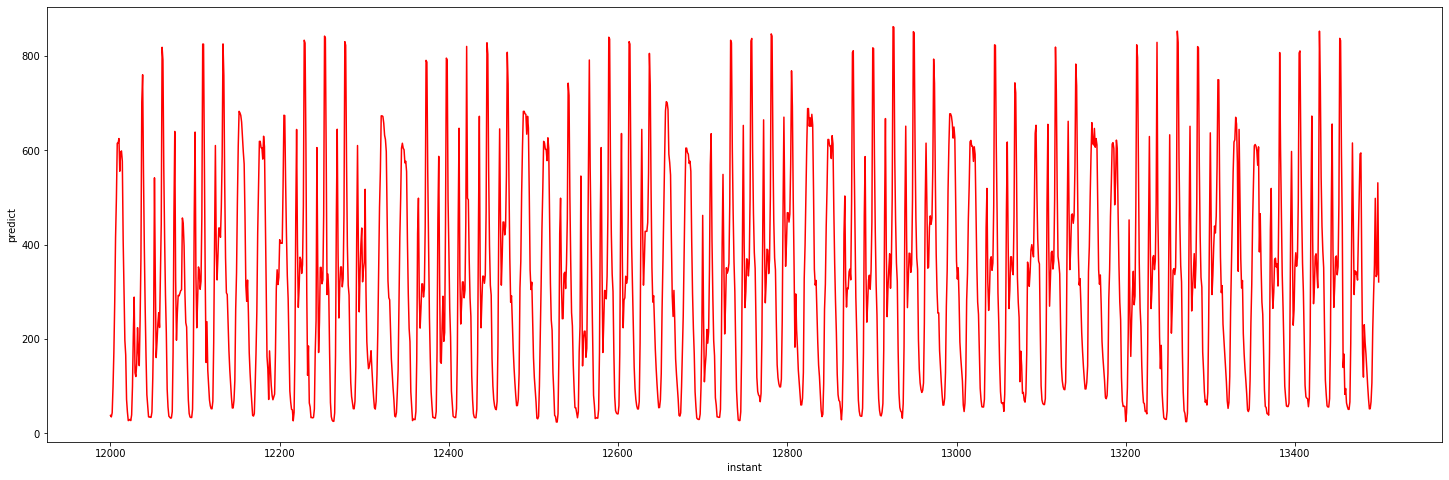

In [63]:
plt.figure(figsize=(25,8))
ax2 = sns.lineplot(
    data=df_test[(df_test['instant'] < 13500)], x='instant', y='predict', color='red'
)

In [64]:
#importancia de features
gbr.feature_importances_

array([0.00340389, 0.00111379, 0.00260282, 0.61787453, 0.00311194,
       0.01332576, 0.07256303, 0.03212198, 0.13175047, 0.12213178])

In [ ]:
# Los gráficos muestran un evidente overfitting
# Hay features que aportan muy poco al modelo y se podrían prescindir